# Lab 5 : Evaluate Naive Bayes Model using pipelines
Summary :
1. Load the dataset into a feature matrix (gray images, resizing and normalization)
2. Create the pipelines
    2.1 Multinomial Naive Bayes
    2.2 Gaussian Naive Bayes
    2.3 Complement Naive Bayes
    2.4 Bernoulli Naive Bayes
    2.5 Categorical Naive Bayes
    2.6 Complex Bayes Net
    2.7 Running the pipelines
3. Evaluate the best models


# 1. Load the dataset (X and Y vector)

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd
import seaborn as sns 

DATASET_PATH = '../data/Fish_Dataset/Fish_Dataset/'

In [2]:
def get_labels():
    folders = os.listdir(DATASET_PATH)
    labels = []
    for f in folders:
        if not('.m' in f) and not('.txt' in f):
            labels.append(f)
    labels = np.array(labels)
    return labels


def get_X_Y(labels):
    # Get the images for each label
    img_shape = (128, 128) #resizing images to this shape ( after converting color image to gray image)
    n_sample_per_class = 600 #Keep only this number of samples per class (expensive complexity issue)
    nb_img = n_sample_per_class*len(labels) #1000 images per class

    X = np.zeros((nb_img, img_shape[0]*img_shape[1])) # feature matrix
    Y = np.zeros(nb_img) #labels vector
    for i in range(len(labels)):
        folder = os.path.join(DATASET_PATH, labels[i], labels[i])
        images = os.listdir(folder)
        np.random.shuffle(images)
        for j in range(n_sample_per_class):
            img_path = os.path.join(folder, images[j])
            img = cv2.imread(img_path, 0) #Load the gray image
            #Resizing
            img = cv2.resize(src=img, dsize=img_shape)
            #Normalization
            img = img/255
            #Add the image in the feature matrix and its labels to the label vector
            X[i*n_sample_per_class+j, :] = img.flatten()
            Y[i*n_sample_per_class+j] = np.argwhere(labels==labels[i])[0]
    return X, Y

labels = get_labels()
X, Y = get_X_Y(labels)
print("Feature matrix : \n", X)
print("Label vector : \n", Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

Feature matrix : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Label vector : 
 [0. 0. 0. ... 8. 8. 8.]


# 2. Pipelines

In [3]:
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config

# Scoring
from sklearn.metrics import roc_auc_score
# PCA
from sklearn.decomposition import PCA

In [4]:
pca = PCA()
set_config(display="diagram")
n_components = [90]

## 2.1 Multinomial Naive Bayes

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

multi_pipe = Pipeline(steps=[('pca', pca), ('MinMaxScaler', MinMaxScaler()), ('multi', MultinomialNB(alpha=0.01))]) # Add a MinMaxScaler to normalize the feature matrix in the range [0, 1] to be computed by the Mulimodal Naive Bayes Model which does not accept negative values
# Do not use class_prior = [0.6, 0.4], it need to have the same number of classes of our dataset (9) and can be computed during the training

multi_params_grid = {
    # 
    # 
    'pca__n_components': n_components,
}
multi_grid_search = GridSearchCV(estimator=multi_pipe, param_grid=multi_params_grid, scoring='accuracy', cv=10)
multi_pipe

Pipeline(steps=[('pca', PCA()), ('MinMaxScaler', MinMaxScaler()),
                ('multi', MultinomialNB(alpha=0.01))])

## 2.2 Gaussian Naive Bayes

In [6]:
from sklearn.naive_bayes import GaussianNB

gauss_pipe = Pipeline(steps=[('pca', pca), ('gauss', GaussianNB())])
gauss_params_grid = {
    # 
    'pca__n_components': n_components,
}
gauss_grid_search = GridSearchCV(estimator=gauss_pipe, param_grid=gauss_params_grid, scoring='accuracy', cv=10)
gauss_pipe

Pipeline(steps=[('pca', PCA()), ('gauss', GaussianNB())])

## 2.3 Complement Naive Bayes 

In [7]:
from sklearn.naive_bayes import ComplementNB

comp_pipe = Pipeline(steps=[('pca', pca), ('MinMaxScaler', MinMaxScaler()), ('comp', ComplementNB())])
comp_params_grid = {
    # 
    'pca__n_components': n_components,
}
comp_grid_search = GridSearchCV(estimator=comp_pipe, param_grid=comp_params_grid, scoring='accuracy', cv=10)
comp_pipe

Pipeline(steps=[('pca', PCA()), ('MinMaxScaler', MinMaxScaler()),
                ('comp', ComplementNB())])

## 2.4 Bernoulli Naive Bayes

In [8]:
from sklearn.naive_bayes import BernoulliNB

bern_pipe = Pipeline(steps=[('pca', pca), ('bern', BernoulliNB())])
bern_params_grid = {
    # 
    'pca__n_components': n_components,
}
bern_grid_search = GridSearchCV(estimator=bern_pipe, param_grid=bern_params_grid, scoring='accuracy', cv=10)
bern_pipe

Pipeline(steps=[('pca', PCA()), ('bern', BernoulliNB())])

## 2.5 Categorical Naive Bayes

In [9]:
from sklearn.naive_bayes import CategoricalNB

cat_pipe = Pipeline(steps=[('pca', pca), ('MinMaxScaler', MinMaxScaler()), ('cat', CategoricalNB())])
cat_params_grid = {
    # 
    'pca__n_components': n_components,
}
cat_grid_search = GridSearchCV(estimator=cat_pipe, param_grid=cat_params_grid, scoring='accuracy', cv=10)
cat_pipe

Pipeline(steps=[('pca', PCA()), ('MinMaxScaler', MinMaxScaler()),
                ('cat', CategoricalNB())])

## 2.6 Complex Bayes Net

In [26]:
from pomegranate import *

small_pca = PCA(n_components=90)

X_pca_train = small_pca.fit_transform(X_train)
model_complex = BayesClassifier.from_samples(MultivariateGaussianDistribution, X_pca_train, y_train)


AttributeError: 'pomegranate.BayesClassifier.BayesClassifier' object has no attribute '__getstate__'

In [15]:
y_pred_BC = model_complex.predict(small_pca.transform(X_test))

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_BC))

              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85       170
         1.0       0.93      0.77      0.84       151
         2.0       0.81      0.93      0.86       158
         3.0       0.85      0.88      0.87       142
         4.0       0.84      0.89      0.86       144
         5.0       0.82      0.80      0.81       137
         6.0       0.97      0.86      0.91       150
         7.0       0.92      0.78      0.85       155
         8.0       0.73      0.94      0.82       143

    accuracy                           0.85      1350
   macro avg       0.86      0.85      0.85      1350
weighted avg       0.86      0.85      0.85      1350



## 2.7 Running the pipelines

Fitting Multinomial model 1 time(s)...
Fitting Gaussian model 1 time(s)...
Fitting Complement model 1 time(s)...
Fitting Bernoulli model 1 time(s)...
Multinomial Naive Bayes Test Accuracy: 0.488
------------------------------
Gaussian Naive Bayes Test Accuracy: 0.634
------------------------------
Complement Naive Bayes Test Accuracy: 0.503
------------------------------
Bernoulli Naive Bayes Test Accuracy: 0.441
------------------------------


<BarContainer object of 4 artists>

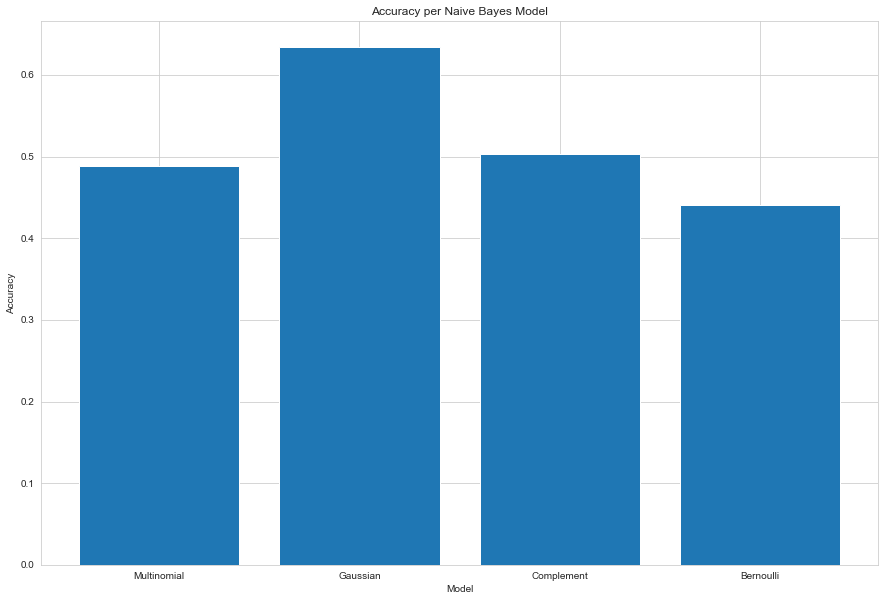

In [24]:
model_list = [
    (multi_params_grid, multi_grid_search, 'Multinomial'),
    (gauss_params_grid, gauss_grid_search, 'Gaussian'),
    (comp_params_grid, comp_grid_search, 'Complement'),
    (bern_params_grid, bern_grid_search, 'Bernoulli'),
    #(cat_params_grid, cat_grid_search, 'Categorical')

]

for grid, pipe, name in model_list:
    
    iterations = 1
    for param in grid.values():
        iterations *= len(param)
        
    print(f'Fitting {name} model {iterations} time(s)...')
    pipe.fit(X_train, y_train)

results = []

for grid, pipe, name in model_list:
    score = pipe.score(X_test, y_test)
    print(f'{name} Naive Bayes Test Accuracy: {np.round(score, 3)}')
    results.append(score)

    print('---'*10)

plt.figure(figsize=(15,10))
plt.title('Accuracy per Naive Bayes Model')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.bar([m[2] for m in model_list], results)

# 3. Evaluating the best models

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay


def get_best_grids(grids, amount=4):
    """
    Sort the grids regarding their test score
    """
    return sorted(grids, key=lambda model_tuple: model_tuple[1].score(X_test,y_test), reverse=True)[:amount]

# Create tuples for the grid : the grid object, prediction of the grid on the test data, probabilities predictions on test data and the name of the used model
best_grids = get_best_grids(model_list)
grid_tuples = [(None, model_complex.predict(small_pca.transform(X_test)), model_complex.predict_proba(small_pca.transform(X_test)), 'Complex')] # Add at the beginning, the complex model which seems to no being able to be fit with a grid search
for pipe, grid, name in best_grids:
    grid_tuples.append((grid, grid.predict(X_test), grid.predict_proba(X_test), name))

In [43]:
def compute_cf_metrics(cm, grid_tuple):
    """
    Compute the metrics (FP, TP, TN, FN, TP, Sensitivity, Specificity, Precision, Recall, Accuracy and AUC) given a confusion matrix
    """
    metrics = {}

    # Compute the FP, FN, TP, TN metrics from the confusion matrix
    FP = (cm.sum(axis=0) - np.diag(cm))
    FN = (cm.sum(axis=1) - np.diag(cm))
    accuracy = np.diag(cm)/cm.sum(axis=0)
    TP = np.diag(cm)
    TN = (cm.sum() - (FP + FN + TP))

    # Save the value in the metrics dictionary
    metrics['FP'] = FP
    metrics['TP'] = TP
    metrics['TN'] = TN
    metrics['FN'] = FN
    metrics['TP'] = TP

    # Sensitivity, hit rate, recall, or true positive rate
    metrics['Sensitivity'] = TP/(TP+FN)
    # Specificity or true negative rate
    metrics['Specificity'] = TN/(TN+FP)
    # Precision or positive predictive value
    metrics['Precision'] = TP/(TP+FP)
    # Recall
    metrics['Recall'] = TP / (TP+FN)
    # Accuracy
    metrics['Accuracy'] = accuracy
    metrics['AUC'] = roc_auc_score(y_test, grid_tuple[2], multi_class='ovr')
    return metrics


def plot_confusion_matrices(axs, grid_tuples):
    cm_list = []
    for i, grid_tuple in enumerate(grid_tuples):
        cm = confusion_matrix(y_test, grid_tuple[1])
        cm_display = ConfusionMatrixDisplay(cm)
        cm_display.plot(ax=axs[i])
        cm_display.ax_.set_title(grid_tuple[-1])
        cm_list.append(cm)
    return cm_list

def display_metrics(cm_list, grid_tuples):
    """
    Display the metrics in a table and plot two histograms to compare the metrics of different models
    :param cm_list: list of confusion matrix of each model
    :param grid_tuples: list of each grid tuple
    :return:
    """
    metrics_df = [] #List of dataframe of averaged computed metrics for each model
    for i in range(len(cm_list)):
        cm_metrics = compute_cf_metrics(cm_list[i], grid_tuples[i])
        df = pd.DataFrame(cm_metrics).transpose()
        mean_metrics = pd.DataFrame(df.mean(axis=1))
        metrics_df.append(mean_metrics)
    #Create a DataFrame with all the results
    metrics_name = metrics_df[-1].index
    metrics_data = [metric_rep.values[:,0] for metric_rep in metrics_df]
    metrics_per_model = pd.DataFrame(metrics_data).T
    metrics_per_model.columns = [grid_tuple[-1] for grid_tuple in grid_tuples]
    metrics_per_model.index = metrics_name

    display_1_df = pd.DataFrame([metrics_per_model.T.FP, metrics_per_model.T.TP,  metrics_per_model.T.TN,  metrics_per_model.T.FN])
    display_2_df = pd.DataFrame([metrics_per_model.T.Sensitivity, metrics_per_model.T.Specificity,  metrics_per_model.T.Precision,  metrics_per_model.T.Recall, metrics_per_model.T.Accuracy, metrics_per_model.T.AUC])

    # Plot the histogram of the averaged metrics for each models
    display_1_df.plot.bar()
    plt.title('Bayes Models evaluation (1/2)')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    display_2_df.plot.bar()
    plt.title('Bayes Models evaluation (2/2)')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    return metrics_per_model


def plot_roc_curves(axs, grid_tuples):
    for i, grid_tuple in enumerate(grid_tuples):
        fpr, tpr, thresholds = roc_curve(y_test, grid_tuple[2][:, 1], pos_label=1)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(ax=axs[i])
        roc_display.ax_.set_title(grid_tuple[-1])

def plot_precision_recall_curves(axs, grid_tuples):
    for i, grid_tuple in enumerate(grid_tuples):
        prec, recall, thresholds = precision_recall_curve(y_test, grid_tuple[2][:, 1], pos_label=1)
        pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
        pr_display.plot(ax=axs[i])
        pr_display.ax_.set_title(grid_tuple[-1])

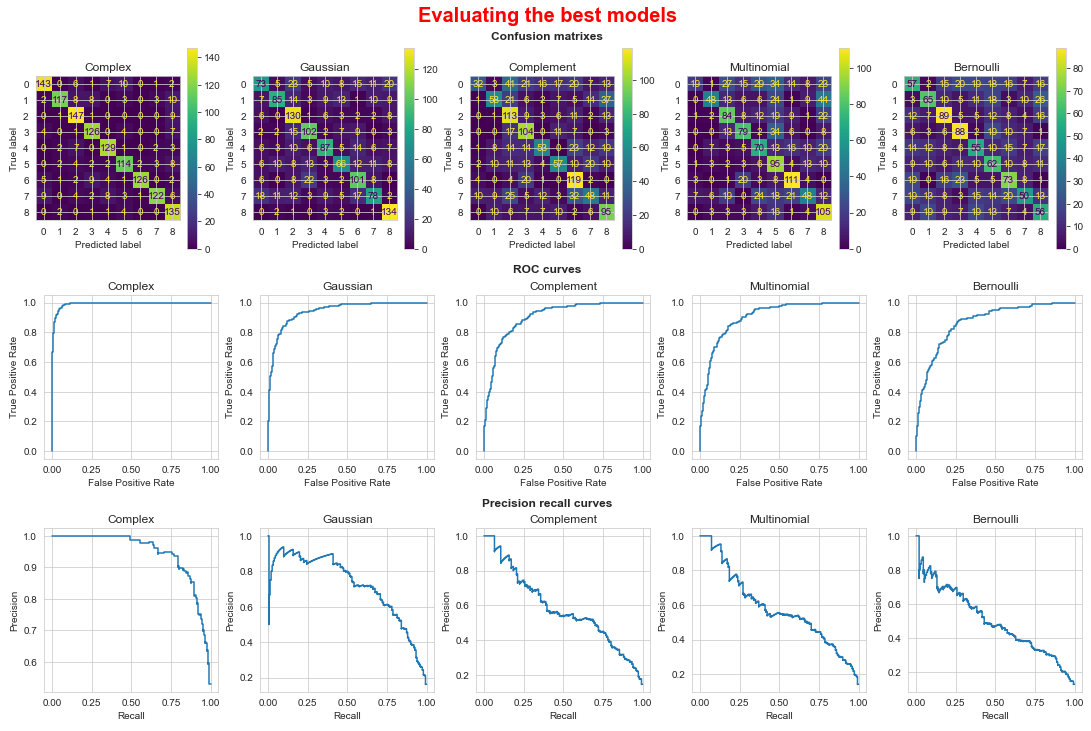

In [44]:
subfigures_titles = ['Confusion matrixes', 'ROC curves', 'Precision recall curves']
subplot_funcs = [plot_confusion_matrices, plot_roc_curves, plot_precision_recall_curves]
cm_list = []

fig = plt.figure(constrained_layout=True, figsize=(15, 10))
fig.suptitle('Evaluating the best models', fontweight='bold', size=20, color='red')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigures_titles[row], fontweight='semibold')

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=5)
    if row==0:
        cm_list = subplot_funcs[row](axs, grid_tuples)
    else:
        subplot_funcs[row](axs, grid_tuples)

### Fill in the table the metrics per Bayes Model :
As we have a multiclass dataset, the metrics has been computed for each class and averaged to be filled in the table

,FP,TP,TN,FN,Sensitivity,Specificity,Precision,Recall,Accuracy,AUC
Complex,21.222222,128.777778,1178.777778,21.222222,0.859202,0.982335,0.865880,0.859202,0.865880,0.990313
Gaussian,54.888889,95.111111,1145.111111,54.888889,0.636996,0.954230,0.635047,0.636996,0.635047,0.928122
Complement,74.555556,75.444444,1125.444444,74.555556,0.507932,0.937918,0.519548,0.507932,0.519548,0.884230
Multinomial,76.777778,73.222222,1123.222222,76.777778,0.497902,0.936246,0.523252,0.497902,0.523252,0.885373
Bernoulli,83.888889,66.111111,1116.111111,83.888889,0.442680,0.930126,0.441578,0.442680,0.441578,0.855355


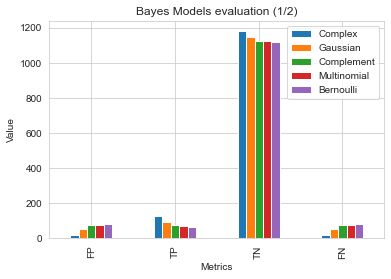

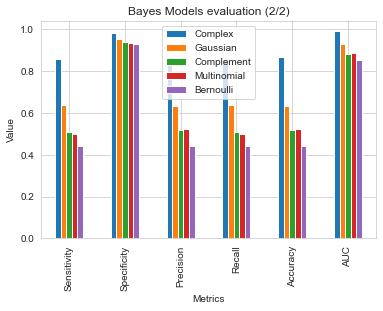

In [45]:
metric_df = display_metrics(cm_list, grid_tuples)
metric_df.T

We can see with the table and the histograms that the **Complex Bayes Model** (with Multivariable Gaussian Distribution assumption) performs very well and much better than the Naives Bayes Models. It is the expected result because the Complex Bayes classifier do not make the assumption that the features have only one parent.